In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
import pingouin as pg
#import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [3]:
# Load file (from same directory as the notebook)
DATA = pd.read_excel(os.path.expanduser("SourceVaccine.xlsx"))

reorder = {k: v for k,v in enumerate([0, 1, 9, 8, 4, 5, 3, 2, 7, 6])}
DATA.insert(2, "condfigs", DATA["cond"].apply(lambda x: reorder[x-1]+1))
DATA.head()

,Response ID,Partnum,condfigs,political,cond,Age,Gender,votereg,Partystr,alreadyvac,vaccine,concernvac,CHANGE_Fbaseline,CHANGE_Cbaseline,CHANGE_F,CHANGE_C,change_k,CHANGE_Kbaseline,Kpre
0,R_01BPjQK4VVSVa6t,1773,8,2,9,66,1,1,3,0,100,2,0.0,-1.0,-1.0,0.0,-1.0,1.0,99.25
1,R_01ITFaONfR3U7SN,617,4,1,7,67,1,1,4,0,100,59,8.0,-1.5,12.0,-2.0,14.0,9.5,55.75
2,R_08JI8chdf3NXC37,1395,5,2,5,46,1,1,4,0,11,96,6.0,-24.5,18.0,-3.0,21.0,30.5,33.00
3,R_0CHD24TUqZu5w1r,537,6,1,6,30,1,1,2,0,92,100,28.0,27.0,-7.0,-30.0,23.0,1.0,26.00
4,R_0dmQ6kfkEfBeInL,1471,6,2,6,25,1,1,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


<IPython.core.display.Javascript object>


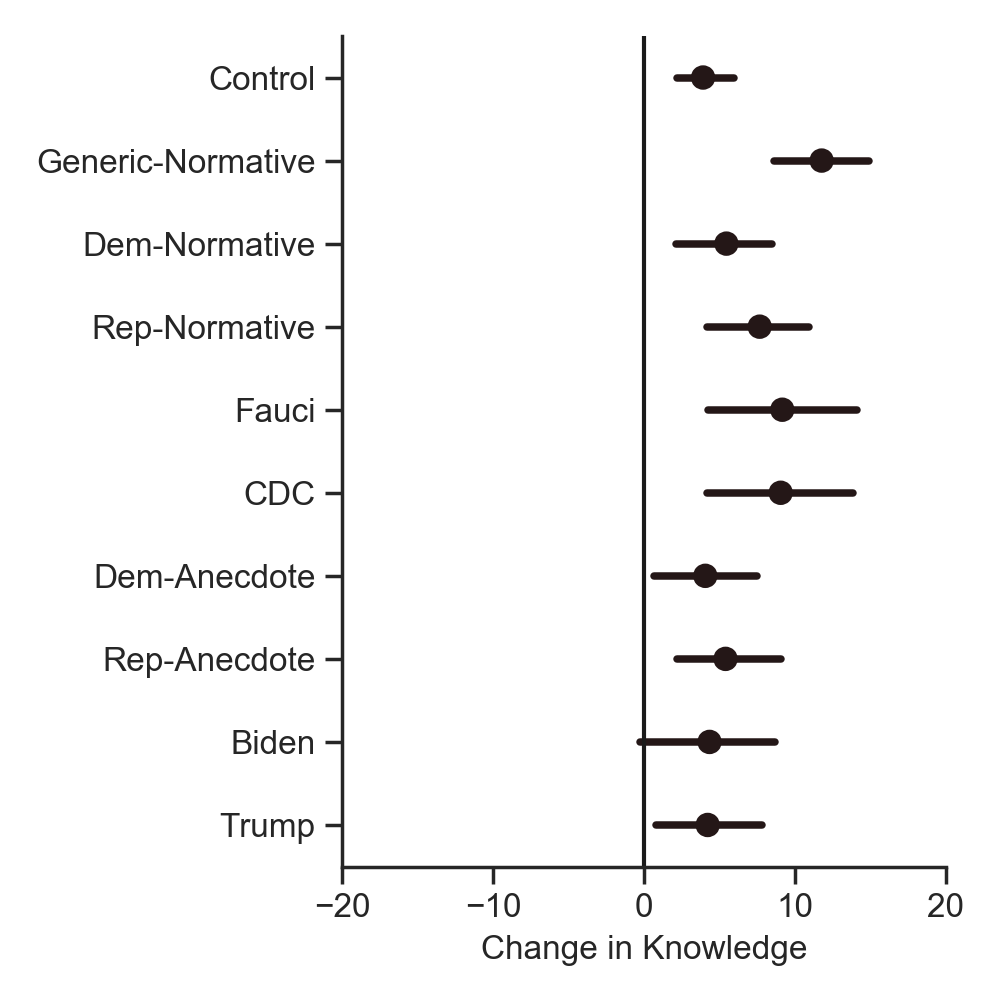

In [4]:
pal = ["#241717"]

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.pointplot(y=DATA.condfigs, x=DATA.change_k, data=DATA, orient="h", \
            palette=pal, join=False, edgecolor=".2", errcolor=".2", \
            ax=ax)
sns.despine()
ax.set_yticklabels(["Control", "Generic-Normative","Dem-Normative", "Rep-Normative", "Fauci", "CDC", "Dem-Anecdote", "Rep-Anecdote","Biden", "Trump"])
ax.set_ylabel("")
ax.set_xlabel("Change in Knowledge")
plt.axvline(x=0, c='k')
plt.xlim(-20,20)

plt.tight_layout()
#plt.savefig('fig.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


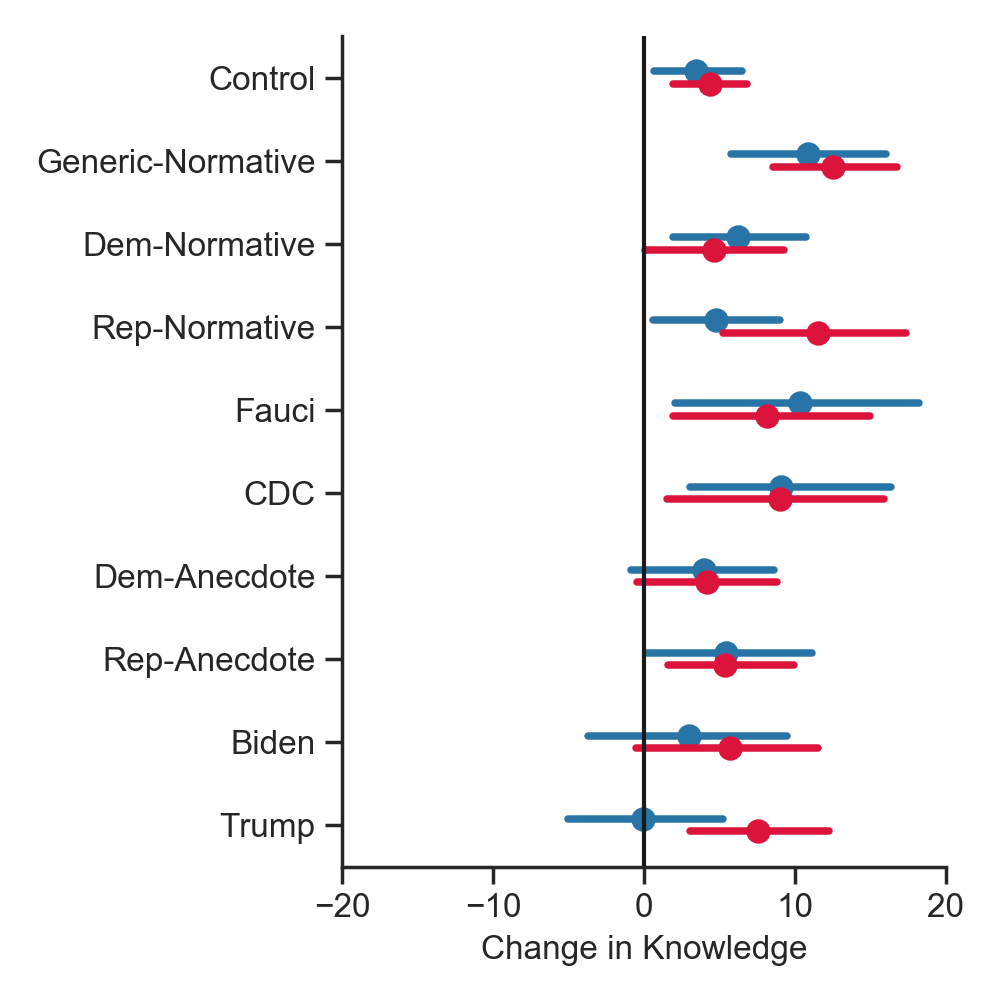

In [5]:
pal = ["#2874A6", "#DC143C"]

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.pointplot(y="condfigs", x="change_k", hue="political", data=DATA, orient="h", \
            palette=pal, dodge=0.15, join=False, edgecolor=".2", errcolor=".2", \
            ax=ax)
sns.despine()
ax.set_yticklabels(["Control", "Generic-Normative","Dem-Normative", "Rep-Normative", "Fauci", "CDC", "Dem-Anecdote", "Rep-Anecdote","Biden", "Trump"])
ax.set_ylabel("")
ax.set_xlabel("Change in Knowledge")
plt.axvline(x=0, c='k')
plt.xlim(-20,20)
ax.get_legend().remove()

plt.tight_layout()
#plt.savefig('fig.tif', dpi=900, format="tiff")

In [9]:
# Load file (from same directory as the notebook)
DATAnovac = pd.read_excel(os.path.expanduser("SourceVaccinenovac.xlsx"))

reorder = {k: v for k,v in enumerate([0, 1, 9, 8, 4, 5, 3, 2, 7, 6])}
DATAnovac.insert(2, "condfigs", DATAnovac["cond"].apply(lambda x: reorder[x-1]+1))
DATAnovac.head()

,Response ID,Partnum,condfigs,political,cond,condcolap,Age,Gender,votereg,Partystr,alreadyvac,vaccine,concernvac,CHANGE_Fbaseline,CHANGE_Cbaseline,CHANGE_F,CHANGE_C,change_k,CHANGE_Kbaseline,changeknormal
0,R_0NVN0anNop6AoH7,996,1,2,1,0,40,0,1,5,0,83,88,9.75,17.00,9.75,17.00,-7.25,-7.25,-3.12500
1,R_0qrtRlH5yzOqB3P,52,1,1,1,0,74,1,1,3,0,100,10,2.50,0.00,2.50,0.00,2.50,2.50,0.51250
2,R_110hRdGtz5Myims,993,1,2,1,0,70,0,1,5,0,100,0,6.00,0.00,6.00,0.00,6.00,6.00,0.53000
3,R_12s8ByL5vVVz0ME,948,1,2,1,0,65,0,1,5,0,100,7,0.50,0.00,0.50,0.00,0.50,0.50,0.50250
4,R_1BWSg0sXKs42BmQ,53,1,1,1,0,47,1,1,3,0,100,1,4.00,6.75,4.00,6.75,-2.75,-2.75,0.48625


In [11]:
%load_ext rpy2.ipython
%R library(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [12]:
%Rpush DATAnovac

In [15]:
# Load file (from same directory as the notebook)
DATp = pd.read_excel(os.path.expanduser("Book6.xlsx"))
reorder = {k: v for k,v in enumerate([0, 1, 9, 8, 4, 5, 3, 2, 7, 6])}
DATp.insert(2, "condfigs", DATp["cond"].apply(lambda x: reorder[x-1]+1))
DATp.head()

,Response ID,Partnum,condfigs,political,cond,Age,Gender,votereg,Partystr,alreadyvac,vaccine,concernvac,CHANGE_Fbaseline,CHANGE_Cbaseline,CHANGE_F,CHANGE_C,change_k,CHANGE_Kbaseline,Kpre
0,R_01BPjQK4VVSVa6t,1773,8,2,9,66,1,1,3,0,100,2,0.0,-1.0,-1.0,0.0,-1.0,1.0,99.25
1,R_01ITFaONfR3U7SN,617,4,1,7,67,1,1,4,0,100,59,8.0,-1.5,12.0,-2.0,14.0,9.5,55.75
2,R_08JI8chdf3NXC37,1395,5,2,5,46,1,1,4,0,11,96,6.0,-24.5,18.0,-3.0,21.0,30.5,33.00
3,R_0CHD24TUqZu5w1r,537,6,1,6,30,1,1,2,0,92,100,28.0,27.0,-7.0,-30.0,23.0,1.0,26.00
4,R_0dmQ6kfkEfBeInL,1471,6,2,6,25,1,1,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


<IPython.core.display.Javascript object>


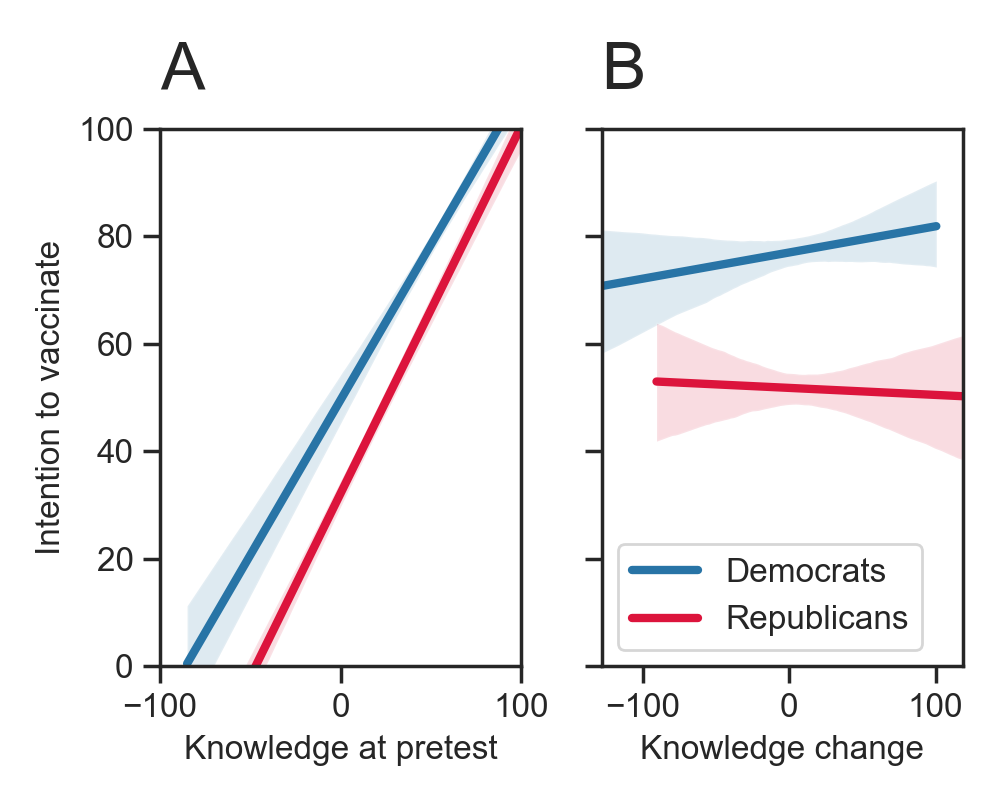

In [16]:
fig, ax = plt.subplots(1,2, figsize=(5,4), sharey=True)

sns.regplot(x=DATp.loc[DATp["political"]==1, "Kpre"], \
            y=DATp.loc[DATp["political"]==1, "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[0])
sns.regplot(x=DATp.loc[DATp["political"]==2, "Kpre"], \
            y=DATp.loc[DATp["political"]==2, "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[0])
ax[0].set_ylabel('Intention to vaccinate')
ax[0].set_xlabel('Knowledge at pretest')


sns.regplot(x=DATp.loc[DATp["political"]==1, "change_k"], \
            y=DATp.loc[DATp["political"]==1, "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=DATp.loc[DATp["political"]==2, "change_k"], \
            y=DATp.loc[DATp["political"]==2, "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Knowledge change')

bff.panellabel(ax[0], "A")
bff.panellabel(ax[1], "B")

plt.tight_layout()
plt.ylim(0,100)
plt.legend(labels=['Democrats', 'Republicans'])
#plt.savefig('fig.tif', dpi=900, format="tiff")

In [18]:
%Rpush DATp

In [19]:
%%R

M <- lm(vaccine ~ change_k:as.factor(political):as.factor(condfigs) + (1 | Partnum), data = DATp)
print(summary(M))


Call:
lm(formula = vaccine ~ change_k:as.factor(political):as.factor(condfigs) + 
    (1 | Partnum), data = DATp)

Residuals:
   Min     1Q Median     3Q    Max 
-81.11 -42.23  17.65  35.43  55.85 

Coefficients: (1 not defined because of singularities)
                                                      Estimate Std. Error
(Intercept)                                          64.049619   1.039953
1 | PartnumTRUE                                             NA         NA
change_k:as.factor(political)1:as.factor(condfigs)1  -0.035569   0.300447
change_k:as.factor(political)2:as.factor(condfigs)1  -0.466584   0.366566
change_k:as.factor(political)1:as.factor(condfigs)2   0.250381   0.148364
change_k:as.factor(political)2:as.factor(condfigs)2  -0.268644   0.157000
change_k:as.factor(political)1:as.factor(condfigs)3   0.089116   0.195720
change_k:as.factor(political)2:as.factor(condfigs)3  -0.069579   0.183625
change_k:as.factor(political)1:as.factor(condfigs)4   0.346024   0.189319
chang

In [3]:
# Load file (from same directory as the notebook)
DATAnovac = pd.read_excel(os.path.expanduser("SourceVaccinenovac.xlsx"))

reorder = {k: v for k,v in enumerate([0, 1, 9, 8, 4, 5, 3, 2, 7, 6])}
DATAnovac.insert(2, "condfigs", DATAnovac["cond"].apply(lambda x: reorder[x-1]+1))
DATAnovac.head()

,Response ID,Partnum,condfigs,political,cond,condcolap,Age,Gender,votereg,Partystr,alreadyvac,vaccine,concernvac,CHANGE_Fbaseline,CHANGE_Cbaseline,CHANGE_F,CHANGE_C,change_k,CHANGE_Kbaseline,changeknormal
0,R_0NVN0anNop6AoH7,996,1,2,1,0,40,0,1,5,0,83,88,9.75,17.00,9.75,17.00,-7.25,-7.25,0.46375
1,R_0qrtRlH5yzOqB3P,52,1,1,1,0,74,1,1,3,0,100,10,2.50,0.00,2.50,0.00,2.50,2.50,0.51250
2,R_110hRdGtz5Myims,993,1,2,1,0,70,0,1,5,0,100,0,6.00,0.00,6.00,0.00,6.00,6.00,0.53000
3,R_12s8ByL5vVVz0ME,948,1,2,1,0,65,0,1,5,0,100,7,0.50,0.00,0.50,0.00,0.50,0.50,0.50250
4,R_1BWSg0sXKs42BmQ,53,1,1,1,0,47,1,1,3,0,100,1,4.00,6.75,4.00,6.75,-2.75,-2.75,0.48625


<IPython.core.display.Javascript object>


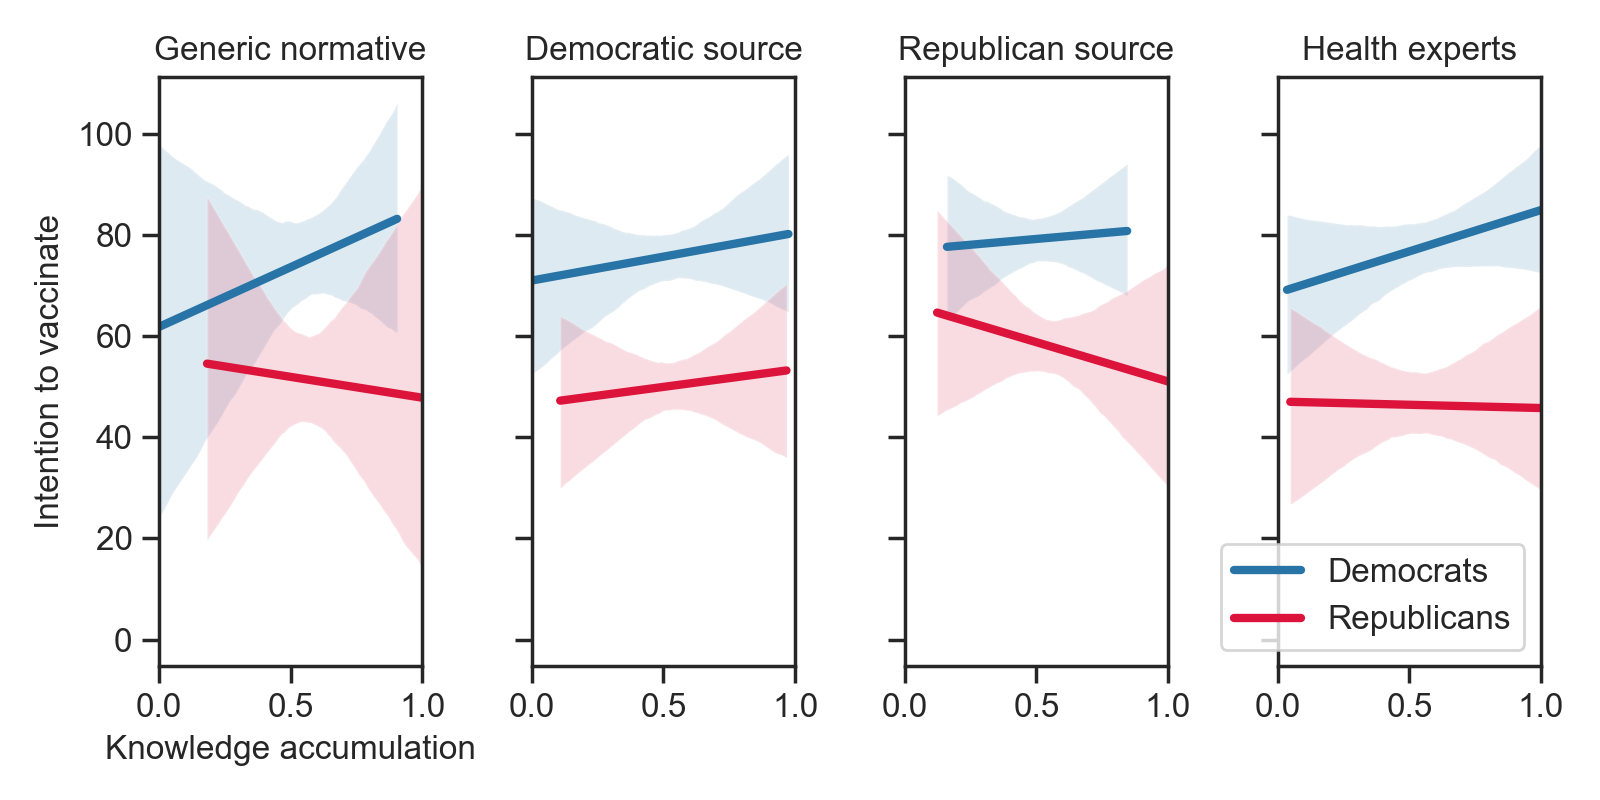

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(8,4), sharey=True)


sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==1, DATAnovac["political"]==1), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==1, DATAnovac["political"]==1), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[0])
sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==1, DATAnovac["political"]==2), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==1, DATAnovac["political"]==2), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[0])



sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==2, DATAnovac["political"]==1), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==2, DATAnovac["political"]==1), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==2, DATAnovac["political"]==2), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==2, DATAnovac["political"]==2), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[1])



sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==3, DATAnovac["political"]==1), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==3, DATAnovac["political"]==1), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[2])
sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==3, DATAnovac["political"]==2), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==3, DATAnovac["political"]==2), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[2])


sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==4, DATAnovac["political"]==1), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==4, DATAnovac["political"]==1), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2874A6","alpha":1,"lw":3}, ax=ax[3])
sns.regplot(x=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==4, DATAnovac["political"]==2), "changeknormal"], \
            y=DATAnovac.loc[np.logical_and(DATAnovac["condcolap"]==4, DATAnovac["political"]==2), "vaccine"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#DC143C","alpha":1,"lw":3}, ax=ax[3])


ax[0].set_ylabel('Intention to vaccinate')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')


ax[0].set_xlabel('Knowledge accumulation')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')


ax[0].set_title("Generic normative")
ax[1].set_title("Democratic source")
ax[2].set_title("Republican source")
ax[3].set_title("Health experts")

ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)
ax[2].set_xlim(0,1)
ax[3].set_xlim(0,1)


plt.legend(labels=['Democrats', 'Republicans'])
plt.tight_layout()
#plt.savefig('figs.tif', dpi=900, format="tiff")

In [23]:
%Rpush DATAnovac

In [24]:
%%R

M <- lm(vaccine ~ change_k:as.factor(political):as.factor(condcolap), data = DATAnovac)
print(summary(M))


Call:
lm(formula = vaccine ~ change_k:as.factor(political):as.factor(condcolap), 
    data = DATAnovac)

Residuals:
   Min     1Q Median     3Q    Max 
-81.27 -43.05  17.73  35.26  54.91 

Coefficients:
                                                     Estimate Std. Error
(Intercept)                                          64.12095    1.03522
change_k:as.factor(political)1:as.factor(condcolap)0 -0.03657    0.30006
change_k:as.factor(political)2:as.factor(condcolap)0 -0.46888    0.36608
change_k:as.factor(political)1:as.factor(condcolap)1  0.24940    0.14817
change_k:as.factor(political)2:as.factor(condcolap)1 -0.26998    0.15679
change_k:as.factor(political)1:as.factor(condcolap)2  0.11375    0.09078
change_k:as.factor(political)2:as.factor(condcolap)2 -0.07908    0.09572
change_k:as.factor(political)1:as.factor(condcolap)3  0.10961    0.12037
change_k:as.factor(political)2:as.factor(condcolap)3 -0.14344    0.09884
change_k:as.factor(political)1:as.factor(condcolap)4  0.18849    0